In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC # SVM algorithm

In [4]:
df = pd.read_csv('diabetes_prediction_dataset.csv')
initial_shape = df.shape
print(f"Dataset Size: {initial_shape}")

#the columns which can be contain outliers
numeric_cols_for_outliers = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

def remove_outliers_iqr(df, columns, factor=1.5):
    df_temp = df.copy()

    is_not_outlier_mask = pd.Series(True, index=df.index)
    
    for col in columns:
        Q1 = df_temp[col].quantile(0.25)
        Q3 = df_temp[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        col_mask = (df_temp[col] >= lower_bound) & (df_temp[col] <= upper_bound)
        is_not_outlier_mask = is_not_outlier_mask & col_mask
        
    df_cleaned = df_temp[is_not_outlier_mask]
    
    return df_cleaned

# Remove outliers
df_cleaned = remove_outliers_iqr(df, numeric_cols_for_outliers)

# Show the results
rows_removed = initial_shape[0] - df_cleaned.shape[0]

print(f"\nCleaned Dataset Size: {df_cleaned.shape}")
print(f"Removed Raw Count(Outliers): {rows_removed} ({rows_removed/initial_shape[0]*100:.2f}%)")
print("\n The first 5 raws of Cleaned Dataset:")
print(df_cleaned.head())

Dataset Size: (100000, 9)

Cleaned Dataset Size: (90387, 9)
Removed Raw Count(Outliers): 9613 (9.61%)

 The first 5 raws of Cleaned Dataset:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  


In [5]:
categorical_cols = ['gender', 'smoking_history']
for col in categorical_cols:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])

X = df_cleaned.drop(columns=['diabetes'])
y = df_cleaned['diabetes']

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

print("The First 5 raws after the preprocessing step:")
print(X_scaled.head())

if X_scaled.isnull().any().any():
    print("\nUYARI: There are NAN values. It changed the median value.")
    X_scaled = X_scaled.fillna(X_scaled.median())

The First 5 raws after the preprocessing step:
     gender       age  hypertension  heart_disease  smoking_history       bmi  \
0 -0.848482  1.710746     -0.265073       5.202932         0.976449 -0.231137   
1 -0.848482  0.558196     -0.265073      -0.192199        -1.132799  0.205441   
2  1.176757 -0.594353     -0.265073      -0.192199         0.976449  0.205441   
3 -0.848482 -0.239722     -0.265073      -0.192199        -0.605487 -0.587779   
4  1.176757  1.533431      3.772539       5.202932        -0.605487 -1.266217   

   HbA1c_level  blood_glucose_level  
0     1.149580             0.154198  
1     1.149580            -1.550459  
2     0.244933             0.665596  
3    -0.458682             0.580363  
4    -0.659715             0.580363  


In [9]:
import matplotlib.pyplot as plt

cov_matrix_1 = X_scaled.cov()
print("Co-variance matrix for dataset1:\n")
print(cov_matrix_1)

Co-variance matrix for dataset1:

                       gender       age  hypertension  heart_disease  \
gender               1.000011 -0.033002      0.016549       0.078210   
age                 -0.033002  1.000011      0.248878       0.229142   
hypertension         0.016549  0.248878      1.000011       0.122335   
heart_disease        0.078210  0.229142      0.122335       1.000011   
smoking_history     -0.076456  0.217764      0.084005       0.023658   
bmi                  0.021201  0.387900      0.130186       0.065943   
HbA1c_level          0.014384  0.051067      0.042291       0.036013   
blood_glucose_level  0.008798  0.047223      0.037561       0.028428   

                     smoking_history       bmi  HbA1c_level  \
gender                     -0.076456  0.021201     0.014384   
age                         0.217764  0.387900     0.051067   
hypertension                0.084005  0.130186     0.042291   
heart_disease               0.023658  0.065943     0.036013   
sm

In [10]:
def strongest_covariances(cov_matrix, top_n=20):
    cov_pairs = cov_matrix.abs().unstack()
    cov_pairs = cov_pairs[cov_pairs < cov_pairs.max()]  # diagonal kaldır
    return cov_pairs.sort_values(ascending=False).head(top_n)

print("Dataset1: Strongest Covariances")
print(strongest_covariances(cov_matrix_1))

Dataset1: Strongest Covariances
gender               gender                 1.000011
age                  age                    1.000011
bmi                  bmi                    1.000011
blood_glucose_level  blood_glucose_level    1.000011
HbA1c_level          HbA1c_level            1.000011
smoking_history      smoking_history        1.000011
hypertension         hypertension           1.000011
bmi                  age                    0.387900
age                  bmi                    0.387900
hypertension         age                    0.248878
age                  hypertension           0.248878
                     heart_disease          0.229142
heart_disease        age                    0.229142
age                  smoking_history        0.217764
smoking_history      age                    0.217764
                     bmi                    0.168128
bmi                  smoking_history        0.168128
hypertension         bmi                    0.130186
bmi           

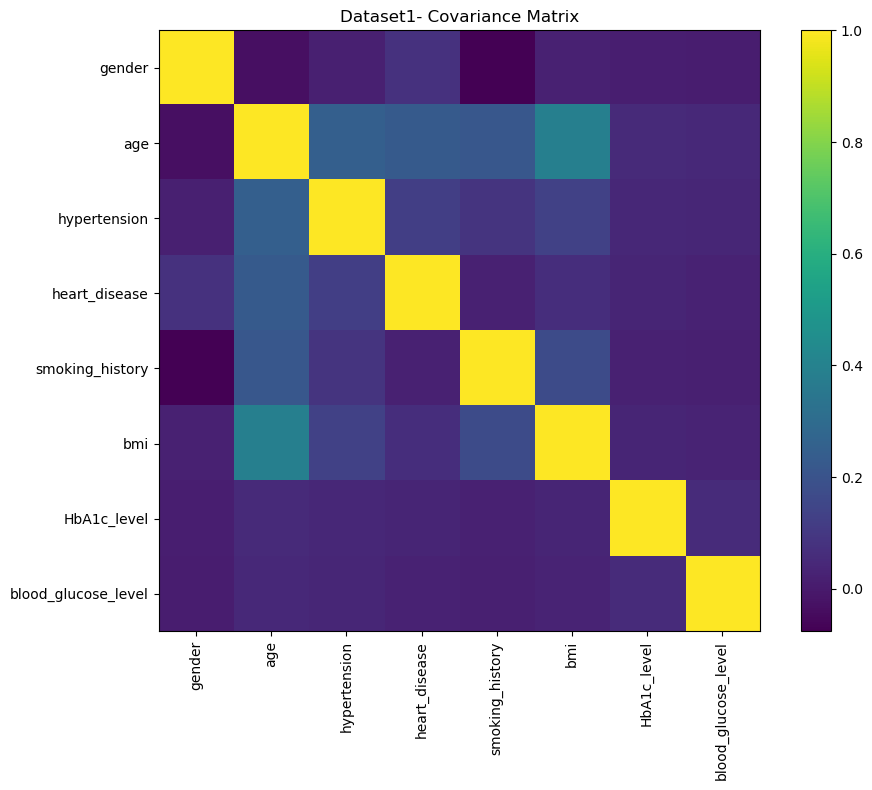

In [11]:
def plot_covariance_matrix(cov_matrix, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(cov_matrix, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    plt.xticks(range(len(cov_matrix.columns)), cov_matrix.columns, rotation=90)
    plt.yticks(range(len(cov_matrix.columns)), cov_matrix.columns)
    plt.tight_layout()
    plt.show()

plot_covariance_matrix(cov_matrix_1, "Dataset1- Covariance Matrix")

In [13]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance = np.cumsum(pca.explained_variance_ratio_)

n_components_95 = np.argmax(explained_variance >= 0.95) + 1

print("For the 95% variance number of features:", n_components_95)

For the 95% variance number of features: 8


In [14]:
pca = PCA(n_components=n_components_95)
X_pca = pca.fit_transform(X_scaled)

loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(n_components_95)],
    index=X.columns
)

feature_importance = loadings.abs().sum(axis=1)

feature_importance = feature_importance.sort_values(ascending=False)

print("Feature Importance According to PCA:\n")
print(feature_importance)

Feature Importance According to PCA:

heart_disease          2.405531
bmi                    2.206851
smoking_history        2.190207
hypertension           2.187809
gender                 2.050301
age                    1.797232
HbA1c_level            1.773629
blood_glucose_level    1.772271
dtype: float64


In [15]:
# explained_variance_ratio_: Her bileşenin verinin ne kadarını temsil ettiği
importance_df = pd.DataFrame({
    'Component': [f'Basis Component {i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Representation Ratio (%)': pca.explained_variance_ratio_ * 100,
    'Cumulative Ratio (%)': np.cumsum(pca.explained_variance_ratio_) * 100
})

# Tabloyu daha okunabilir kılmak için yuvarlama yapalım
importance_df = importance_df.round(2)

print("--- PCA Variances Tables ---")
print(importance_df.to_string(index=False))

# 5. Opsiyonel: Hangi orijinal özelliğin veriyi en çok temsil ettiğini (PC1 bazında) gör
loadings = pd.DataFrame(
    np.abs(pca.components_[0]), 
    index=X_scaled.columns, 
    columns=['impact_score']
).sort_values(by='impact_score', ascending=False)

print("\n--- Features Contributing Most to the First Component (The Most Significant Part) ---")
print(loadings)

--- PCA Variances Tables ---
        Component  Representation Ratio (%)  Cumulative Ratio (%)
Basis Component 1                     21.83                 21.83
Basis Component 2                     13.95                 35.78
Basis Component 3                     12.85                 48.63
Basis Component 4                     11.82                 60.45
Basis Component 5                     11.54                 71.98
Basis Component 6                     10.78                 82.77
Basis Component 7                     10.33                 93.10
Basis Component 8                      6.90                100.00

--- Features Contributing Most to the First Component (The Most Significant Part) ---
                     impact_score
age                      0.599568
bmi                      0.495725
hypertension             0.388831
smoking_history          0.346494
heart_disease            0.312248
HbA1c_level              0.119951
blood_glucose_level      0.107847
gender            

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=42, stratify=y
)

# 6. Standard Scaler İşlemi
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
#Logistic Regression
model = LogisticRegression(max_iter=100)
model.fit(X_train_scaled, y_train)

# 8. Test Etme ve Sonuçları Raporlama
y_pred = model.predict(X_test_scaled)

print("\n--- Model Results ---")
print(f"Accuracy (Doğruluk) Skoru: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


--- Model Results ---
Accuracy (Doğruluk) Skoru: 0.9642

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17179
           1       0.80      0.37      0.51       899

    accuracy                           0.96     18078
   macro avg       0.88      0.68      0.75     18078
weighted avg       0.96      0.96      0.96     18078



In [18]:
#LR with class weight parameter
best_lr_model = LogisticRegression(
    C=1, 
    penalty='l2', 
    solver='lbfgs', 
    class_weight='balanced', # For the unbalanced dataset
    max_iter=200
)
best_lr_model.fit(X_train_scaled, y_train)
y_pred2 = best_lr_model.predict(X_test_scaled)

print(f"Final Model Accuracy: {accuracy_score(y_test, y_pred2):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred2))

Final Model Accuracy: 0.8438

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91     17179
           1       0.22      0.87      0.36       899

    accuracy                           0.84     18078
   macro avg       0.61      0.85      0.63     18078
weighted avg       0.95      0.84      0.88     18078



In [19]:
#Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model using the scaled data
rf_model.fit(X_train_scaled, y_train)

print("Random Forest Model Trained Successfully.")

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_scaled)
print("\n--- Model Evaluation Results ---")

# 4a. Accuracy Score
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy Score: {accuracy:.4f}\n")

# 4b. Classification Report (Provides Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Model Trained Successfully.

--- Model Evaluation Results ---
Accuracy Score: 0.9712

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     17179
           1       0.90      0.47      0.62       899

    accuracy                           0.97     18078
   macro avg       0.94      0.74      0.80     18078
weighted avg       0.97      0.97      0.97     18078



In [20]:
#Random Forest with class weight parameter
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample',random_state=42)

# Train the model using the scaled data
rf_model.fit(X_train_scaled, y_train)

print("Random Forest Model Trained Successfully.")

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_scaled)
print("\n--- Model Evaluation Results ---")

# 4a. Accuracy Score
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy Score: {accuracy:.4f}\n")

# 4b. Classification Report (Provides Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Model Trained Successfully.

--- Model Evaluation Results ---
Accuracy Score: 0.9703

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17179
           1       0.87      0.47      0.61       899

    accuracy                           0.97     18078
   macro avg       0.92      0.73      0.80     18078
weighted avg       0.97      0.97      0.97     18078



In [21]:
#SVM with linear kernel

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_scaled, y_train)
print("\n--- SVM Model Complete Training ---")

y_pred_svm = svm_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_svm)
print(f"\n (Accuracy): {accuracy:.4f}\n")

print("--- Classification_report ---")
print(classification_report(y_test, y_pred_svm))


--- SVM Model Complete Training ---

 (Accuracy): 0.9625

--- Classification_report ---
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     17179
           1       0.96      0.26      0.40       899

    accuracy                           0.96     18078
   macro avg       0.96      0.63      0.69     18078
weighted avg       0.96      0.96      0.95     18078



In [22]:
svm_model = SVC(kernel='linear', class_weight='balanced',random_state=42)
svm_model.fit(X_train_scaled, y_train)

print("\n--- SVM Model Complete Training ---")

y_pred_svm = svm_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_svm)
print(f"\n (Accuracy): {accuracy:.4f}\n")

print("--- Classification_report ---")
print(classification_report(y_test, y_pred_svm))


--- SVM Model Complete Training ---

 (Accuracy): 0.8360

--- Classification_report ---
              precision    recall  f1-score   support

           0       0.99      0.83      0.91     17179
           1       0.22      0.87      0.35       899

    accuracy                           0.84     18078
   macro avg       0.60      0.85      0.63     18078
weighted avg       0.95      0.84      0.88     18078



In [23]:
#SVM with rbf kernel
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)

print("\n--- SVM Model Complete Training ---")

y_pred_svm = svm_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_svm)
print(f"\n (Accuracy): {accuracy:.4f}\n")

print("--- Classification_report ---")
print(classification_report(y_test, y_pred_svm))


--- SVM Model Complete Training ---

 (Accuracy): 0.9660

--- Classification_report ---
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17179
           1       0.97      0.32      0.49       899

    accuracy                           0.97     18078
   macro avg       0.97      0.66      0.73     18078
weighted avg       0.97      0.97      0.96     18078



In [24]:
#SVM with rbf kernel gamma 0.01 
svm_model = SVC(kernel='rbf', gamma = 0.01, random_state=42)
svm_model.fit(X_train_scaled, y_train)

print("\n--- SVM Model Complete Training ---")

y_pred_svm = svm_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_svm)
print(f"\n (Accuracy): {accuracy:.4f}\n")

print("--- Classification_report ---")
print(classification_report(y_test, y_pred_svm))


--- SVM Model Complete Training ---

 (Accuracy): 0.9623

--- Classification_report ---
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     17179
           1       0.92      0.26      0.41       899

    accuracy                           0.96     18078
   macro avg       0.94      0.63      0.70     18078
weighted avg       0.96      0.96      0.95     18078



In [25]:
#SVM with rbf kernel gamma 0.1 
svm_model = SVC(kernel='rbf', gamma = 0.1, random_state=42)
svm_model.fit(X_train_scaled, y_train)

print("\n--- SVM Model Complete Training ---")

y_pred_svm = svm_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_svm)
print(f"\n (Accuracy): {accuracy:.4f}\n")

print("--- Classification_report ---")
print(classification_report(y_test, y_pred_svm))


--- SVM Model Complete Training ---

 (Accuracy): 0.9658

--- Classification_report ---
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17179
           1       0.98      0.32      0.48       899

    accuracy                           0.97     18078
   macro avg       0.97      0.66      0.73     18078
weighted avg       0.97      0.97      0.96     18078



In [26]:
#SVM with rbf kernel gamma 1 
svm_model = SVC(kernel='rbf', gamma = 1, random_state=42)
svm_model.fit(X_train_scaled, y_train)

print("\n--- SVM Model Complete Training ---")

y_pred_svm = svm_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_svm)
print(f"\n (Accuracy): {accuracy:.4f}\n")

print("--- Classification_report ---")
print(classification_report(y_test, y_pred_svm))


--- SVM Model Complete Training ---

 (Accuracy): 0.9680

--- Classification_report ---
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17179
           1       0.94      0.38      0.54       899

    accuracy                           0.97     18078
   macro avg       0.96      0.69      0.76     18078
weighted avg       0.97      0.97      0.96     18078



In [27]:
#SVM with polynomial kernel
svm_model = SVC(kernel='poly', random_state=42)
svm_model.fit(X_train_scaled, y_train)

print("\n--- SVM Model Complete Training ---")

y_pred_svm = svm_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_svm)
print(f"\n (Accuracy): {accuracy:.4f}\n")

print("--- Classification_report ---")
print(classification_report(y_test, y_pred_svm))


--- SVM Model Complete Training ---

 (Accuracy): 0.9656

--- Classification_report ---
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17179
           1       0.98      0.32      0.48       899

    accuracy                           0.97     18078
   macro avg       0.97      0.66      0.73     18078
weighted avg       0.97      0.97      0.96     18078



In [28]:
#SVM with polynomial kernel, gamma 0.01
svm_model = SVC(kernel='poly', gamma = 0.01, random_state=42)
svm_model.fit(X_train_scaled, y_train)

print("\n--- SVM Model Complete Training ---")

y_pred_svm = svm_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_svm)
print(f"\n (Accuracy): {accuracy:.4f}\n")

print("--- Classification_report ---")
print(classification_report(y_test, y_pred_svm))


--- SVM Model Complete Training ---

 (Accuracy): 0.9529

--- Classification_report ---
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     17179
           1       0.96      0.06      0.11       899

    accuracy                           0.95     18078
   macro avg       0.96      0.53      0.54     18078
weighted avg       0.95      0.95      0.93     18078



In [29]:
#SVM with polynomial kernel, gamma 0.1
svm_model = SVC(kernel='poly', gamma = 0.1, random_state=42)
svm_model.fit(X_train_scaled, y_train)

print("\n--- SVM Model Complete Training ---")

y_pred_svm = svm_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_svm)
print(f"\n (Accuracy): {accuracy:.4f}\n")

print("--- Classification_report ---")
print(classification_report(y_test, y_pred_svm))


--- SVM Model Complete Training ---

 (Accuracy): 0.9656

--- Classification_report ---
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17179
           1       0.98      0.32      0.48       899

    accuracy                           0.97     18078
   macro avg       0.97      0.66      0.73     18078
weighted avg       0.97      0.97      0.96     18078



In [30]:
#SVM with sigmoid kernel
svm_model = SVC(kernel='sigmoid', random_state=42)
svm_model.fit(X_train_scaled, y_train)

print("\n--- SVM Model Complete Training ---")

y_pred_svm = svm_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_svm)
print(f"\n (Accuracy): {accuracy:.4f}\n")

print("--- Classification_report ---")
print(classification_report(y_test, y_pred_svm))


--- SVM Model Complete Training ---

 (Accuracy): 0.9383

--- Classification_report ---
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     17179
           1       0.37      0.35      0.36       899

    accuracy                           0.94     18078
   macro avg       0.67      0.66      0.66     18078
weighted avg       0.94      0.94      0.94     18078



In [31]:
#SVM with sigmoid kernel, gamma 0.01
svm_model = SVC(kernel='sigmoid', gamma = 0.01, random_state=42)
svm_model.fit(X_train_scaled, y_train)

print("\n--- SVM Model Complete Training ---")

y_pred_svm = svm_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_svm)
print(f"\n (Accuracy): {accuracy:.4f}\n")

print("--- Classification_report ---")
print(classification_report(y_test, y_pred_svm))


--- SVM Model Complete Training ---

 (Accuracy): 0.9582

--- Classification_report ---
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17179
           1       0.68      0.30      0.41       899

    accuracy                           0.96     18078
   macro avg       0.82      0.64      0.70     18078
weighted avg       0.95      0.96      0.95     18078



In [33]:
#SVM with sigmoid kernel, gamma 0.1
svm_model = SVC(kernel='sigmoid', gamma = 0.1, random_state=42)
svm_model.fit(X_train_scaled, y_train)

print("\n--- SVM Model Complete Training ---")

y_pred_svm = svm_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_svm)
print(f"\n (Accuracy): {accuracy:.4f}\n")

print("--- Classification_report ---")
print(classification_report(y_test, y_pred_svm))


--- SVM Model Complete Training ---

 (Accuracy): 0.9387

--- Classification_report ---
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     17179
           1       0.37      0.35      0.36       899

    accuracy                           0.94     18078
   macro avg       0.67      0.66      0.66     18078
weighted avg       0.94      0.94      0.94     18078



In [34]:
#SVR - linear
from sklearn.svm import SVR
svr_model = SVR(kernel='linear')
svr_model.fit(X_train_scaled, y_train)

y_pred_continuous = svr_model.predict(X_test_scaled)

THRESHOLD = 0.5
y_pred_binary = (y_pred_continuous >= THRESHOLD).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy Score: {accuracy:.4f}\n")

print("--- SVR (Thresholded) Classification Metrics ---")
print(classification_report(y_test, y_pred_binary))

Accuracy Score: 0.9503

--- SVR (Thresholded) Classification Metrics ---
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     17179
           1       0.00      0.00      0.00       899

    accuracy                           0.95     18078
   macro avg       0.48      0.50      0.49     18078
weighted avg       0.90      0.95      0.93     18078



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
#SVR - rbf
from sklearn.svm import SVR
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_scaled, y_train)

y_pred_continuous = svr_model.predict(X_test_scaled)

THRESHOLD = 0.5
y_pred_binary = (y_pred_continuous >= THRESHOLD).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy Score: {accuracy:.4f}\n")

print("--- SVR (Thresholded) Classification Metrics ---")
print(classification_report(y_test, y_pred_binary))

Accuracy Score: 0.9650

--- SVR (Thresholded) Classification Metrics ---
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     17179
           1       0.98      0.30      0.46       899

    accuracy                           0.96     18078
   macro avg       0.97      0.65      0.72     18078
weighted avg       0.97      0.96      0.96     18078



In [37]:
#SVR - rbf gamma 0.01
from sklearn.svm import SVR
svr_model = SVR(kernel='rbf', gamma = 0.01)
svr_model.fit(X_train_scaled, y_train)

y_pred_continuous = svr_model.predict(X_test_scaled)

THRESHOLD = 0.5
y_pred_binary = (y_pred_continuous >= THRESHOLD).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy Score: {accuracy:.4f}\n")

print("--- SVR (Thresholded) Classification Metrics ---")
print(classification_report(y_test, y_pred_binary))

Accuracy Score: 0.9606

--- SVR (Thresholded) Classification Metrics ---
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     17179
           1       0.99      0.21      0.35       899

    accuracy                           0.96     18078
   macro avg       0.97      0.61      0.66     18078
weighted avg       0.96      0.96      0.95     18078



In [38]:
#SVR - rbf gamma 0.1
from sklearn.svm import SVR
svr_model = SVR(kernel='rbf', gamma = 0.1)
svr_model.fit(X_train_scaled, y_train)

y_pred_continuous = svr_model.predict(X_test_scaled)

THRESHOLD = 0.5
y_pred_binary = (y_pred_continuous >= THRESHOLD).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy Score: {accuracy:.4f}\n")

print("--- SVR (Thresholded) Classification Metrics ---")
print(classification_report(y_test, y_pred_binary))

Accuracy Score: 0.9635

--- SVR (Thresholded) Classification Metrics ---
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     17179
           1       0.98      0.27      0.43       899

    accuracy                           0.96     18078
   macro avg       0.97      0.64      0.70     18078
weighted avg       0.96      0.96      0.95     18078



In [39]:
#SVR - rbf gamma 1
from sklearn.svm import SVR
svr_model = SVR(kernel='rbf', gamma = 1)
svr_model.fit(X_train_scaled, y_train)

y_pred_continuous = svr_model.predict(X_test_scaled)

THRESHOLD = 0.5
y_pred_binary = (y_pred_continuous >= THRESHOLD).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy Score: {accuracy:.4f}\n")

print("--- SVR (Thresholded) Classification Metrics ---")
print(classification_report(y_test, y_pred_binary))

Accuracy Score: 0.9686

--- SVR (Thresholded) Classification Metrics ---
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17179
           1       0.93      0.40      0.56       899

    accuracy                           0.97     18078
   macro avg       0.95      0.70      0.77     18078
weighted avg       0.97      0.97      0.96     18078



In [40]:
#SVR - polynomial
from sklearn.svm import SVR
svr_model = SVR(kernel='poly')
svr_model.fit(X_train_scaled, y_train)

y_pred_continuous = svr_model.predict(X_test_scaled)

THRESHOLD = 0.5
y_pred_binary = (y_pred_continuous >= THRESHOLD).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy Score: {accuracy:.4f}\n")

print("--- SVR (Thresholded) Classification Metrics ---")
print(classification_report(y_test, y_pred_binary))

Accuracy Score: 0.9585

--- SVR (Thresholded) Classification Metrics ---
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     17179
           1       0.99      0.17      0.29       899

    accuracy                           0.96     18078
   macro avg       0.98      0.58      0.63     18078
weighted avg       0.96      0.96      0.94     18078



In [41]:
#SVR - polynomial gamma 0.01
from sklearn.svm import SVR
svr_model = SVR(kernel='poly', gamma = 0.01)
svr_model.fit(X_train_scaled, y_train)

y_pred_continuous = svr_model.predict(X_test_scaled)

THRESHOLD = 0.5
y_pred_binary = (y_pred_continuous >= THRESHOLD).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy Score: {accuracy:.4f}\n")

print("--- SVR (Thresholded) Classification Metrics ---")
print(classification_report(y_test, y_pred_binary))

Accuracy Score: 0.9542

--- SVR (Thresholded) Classification Metrics ---
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     17179
           1       0.97      0.08      0.15       899

    accuracy                           0.95     18078
   macro avg       0.96      0.54      0.56     18078
weighted avg       0.96      0.95      0.94     18078



In [42]:
#SVR - polynomial gamma 0.1
from sklearn.svm import SVR
svr_model = SVR(kernel='poly', gamma = 0.1)
svr_model.fit(X_train_scaled, y_train)

y_pred_continuous = svr_model.predict(X_test_scaled)

THRESHOLD = 0.5
y_pred_binary = (y_pred_continuous >= THRESHOLD).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy Score: {accuracy:.4f}\n")

print("--- SVR (Thresholded) Classification Metrics ---")
print(classification_report(y_test, y_pred_binary))

Accuracy Score: 0.9585

--- SVR (Thresholded) Classification Metrics ---
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     17179
           1       0.99      0.17      0.29       899

    accuracy                           0.96     18078
   macro avg       0.98      0.58      0.63     18078
weighted avg       0.96      0.96      0.94     18078



In [43]:
#SVR - sigmoid
from sklearn.svm import SVR
svr_model = SVR(kernel='sigmoid')
svr_model.fit(X_train_scaled, y_train)

y_pred_continuous = svr_model.predict(X_test_scaled)

THRESHOLD = 0.5
y_pred_binary = (y_pred_continuous >= THRESHOLD).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy Score: {accuracy:.4f}\n")

print("--- SVR (Thresholded) Classification Metrics ---")
print(classification_report(y_test, y_pred_binary))

Accuracy Score: 0.5032

--- SVR (Thresholded) Classification Metrics ---
              precision    recall  f1-score   support

           0       0.95      0.51      0.66     17179
           1       0.04      0.44      0.08       899

    accuracy                           0.50     18078
   macro avg       0.49      0.47      0.37     18078
weighted avg       0.90      0.50      0.63     18078



In [44]:
#SVR - sigmoid gamma 0.01
from sklearn.svm import SVR
svr_model = SVR(kernel='sigmoid', gamma = 0.01)
svr_model.fit(X_train_scaled, y_train)

y_pred_continuous = svr_model.predict(X_test_scaled)

THRESHOLD = 0.5
y_pred_binary = (y_pred_continuous >= THRESHOLD).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy Score: {accuracy:.4f}\n")

print("--- SVR (Thresholded) Classification Metrics ---")
print(classification_report(y_test, y_pred_binary))

Accuracy Score: 0.9106

--- SVR (Thresholded) Classification Metrics ---
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     17179
           1       0.01      0.01      0.01       899

    accuracy                           0.91     18078
   macro avg       0.48      0.48      0.48     18078
weighted avg       0.90      0.91      0.91     18078



In [45]:
#SVR - sigmoid gamma 0.1
from sklearn.svm import SVR
svr_model = SVR(kernel='sigmoid', gamma = 0.1)
svr_model.fit(X_train_scaled, y_train)

y_pred_continuous = svr_model.predict(X_test_scaled)

THRESHOLD = 0.5
y_pred_binary = (y_pred_continuous >= THRESHOLD).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy Score: {accuracy:.4f}\n")

print("--- SVR (Thresholded) Classification Metrics ---")
print(classification_report(y_test, y_pred_binary))

Accuracy Score: 0.4905

--- SVR (Thresholded) Classification Metrics ---
              precision    recall  f1-score   support

           0       0.94      0.50      0.65     17179
           1       0.04      0.37      0.07       899

    accuracy                           0.49     18078
   macro avg       0.49      0.43      0.36     18078
weighted avg       0.89      0.49      0.62     18078



In [46]:
#DecisionTree
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)

dt_model.fit(X_train_scaled, y_train)
print("Decision Tree Model Trained Successfully.")


y_pred2 = dt_model.predict(X_test_scaled)
print("\n--- Model Evaluation Results ---")

accuracy2 = accuracy_score(y_test, y_pred2)
print(f"Accuracy Score: {accuracy2:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred2))

Decision Tree Model Trained Successfully.

--- Model Evaluation Results ---
Accuracy Score: 0.9732

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     17179
           1       1.00      0.46      0.63       899

    accuracy                           0.97     18078
   macro avg       0.99      0.73      0.81     18078
weighted avg       0.97      0.97      0.97     18078



In [47]:
#DecisionTree
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(max_depth=None, random_state=42)

dt_model.fit(X_train_scaled, y_train)
print("Decision Tree Model Trained Successfully.")


y_pred2 = dt_model.predict(X_test_scaled)
print("\n--- Model Evaluation Results ---")

accuracy2 = accuracy_score(y_test, y_pred2)
print(f"Accuracy Score: {accuracy2:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred2))

Decision Tree Model Trained Successfully.

--- Model Evaluation Results ---
Accuracy Score: 0.9510

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     17179
           1       0.51      0.55      0.53       899

    accuracy                           0.95     18078
   macro avg       0.74      0.76      0.75     18078
weighted avg       0.95      0.95      0.95     18078



In [48]:
#GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
# k range For the data 18.000 
param_grid = {'n_neighbors': [7, 9, 11, 13, 15, 17, 19, 21]}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

print(f"The best neighbor count: {grid.best_params_['n_neighbors']}")

The best neighbor count: 17


In [49]:
#KNN
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train_scaled, y_train)


y_pred = knn.predict(X_test_scaled)
print(f"Doğruluk: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Doğruluk: 0.9644319061843124
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17179
           1       0.92      0.31      0.47       899

    accuracy                           0.96     18078
   macro avg       0.94      0.66      0.72     18078
weighted avg       0.96      0.96      0.96     18078



In [50]:
#GNB
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9093926319283107
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     17179
           1       0.24      0.38      0.30       899

    accuracy                           0.91     18078
   macro avg       0.60      0.66      0.62     18078
weighted avg       0.93      0.91      0.92     18078

[[16094  1085]
 [  553   346]]
